# Analysing the $mBasicPH\_storage$ model

## Settings

For working with the model, we first import some packages and the modelclass:

In [1]:
# In case, working directory is not set correctly
#os.chdir('C:\\Users\\mpher\\Documents\\Uni\\Master\\02_Exchange\\01_Academics\\Energy Economics of the Green Transition\\0_Final Project\EnergyEconGroupWork')

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)

c:\Users\mpher\Documents\Uni\Master\02_Exchange\01_Academics\Energy Economics of the Green Transition\EnergyEconGroupWork


In [3]:
%run ./stdPackages.ipynb
from pyDbs import *

os.chdir(os.path.join(d['curr'], 'py'))

from mBasicPH_storage import *
os.chdir(d['curr'])

Next we load the database:

In [4]:
kwargs = {'variables': ['Fundamentals', 'LoadVariables', 'GeneratorsVariables','StorageVariables','TransmissionLines'],
        'maps': ['LoadMaps','GeneratorsMaps','StorageMaps','MarketMaps','hMaps'],
        'variable2D': ['HourlyVariation'],
        'scalars': ['Scalars']}

path_to_data = os.path.join(d['curr'], 'Data', 'mBasicPH_storage_Data.xlsx')

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Convert variables to floats:

In [5]:
[db.__setitem__(var,db[var].astype(float).sort_index()) for var in db.getTypes('variable').keys()];

We need to read in heat areas manually:

In [6]:
db['g_H'] = db['id2g_H'].get_level_values('g_H').unique()

In [7]:
db['g_H']

Index(['DK_Central'], dtype='object', name='g_H')

We need to read in electricity areas manually:

In [8]:
db['g_E'] = db['id2g_E'].get_level_values('g_E').unique()

In [9]:
db['g_E']

Index(['DK'], dtype='object', name='g_E')

Collect all areas in one:

In [10]:
db['g'] = db['g_E'].copy()

## Initialze Baseline Model and Debug

In [11]:
m=mSimple(db)
m.db.symbols.keys()

dict_keys(['FuelPrice', 'EmissionTax', 'EmissionIntensity', 'LoadVariation_H', 'Load_E', 'Load_H', 'LoadVariation_E', 'GeneratingCap_E', 'FuelMix', 'GeneratingCap_H', 'OtherMC', 'FOM', 'E2H', 'effD', 'effC', 'chargeCap_H', 'selfDischarge', 'sCap', 'lineFOM', 'lineCapacity', 'lineMC', 'c_E2g_E', 'c_H2g_H', 'tech2modelTech', 'id2hvt', 'id2g_E', 'id2g_H', 'id2tech', 'g_E2g_H', 'g_E2g', 'g_H2g', 'h2Week', 'h2Weekday', 'h2Month', 'h2HourOfTheDay', 'CapVariation', 'MWP_E', 'MWP_H', 'lineLoss', 'BFt', 'EmissionType', 'c_H', 'h', 'c_E', 'id', 'g_E', 'g_E_alias', 'hvt', 'g_H', 'g', 'gConnected', 'id2modelTech2tech'])

The problem was, that the storage was not correctly mapped to the heating area. Now it is included in the index below. You can check so by searching for *id_DK_Central_HS* and *id_DK_Decentral_HS*.

In [12]:
m.db['id2g_H']

MultiIndex([(        'id_DK_Central_BH_Biogas', 'DK_Central'),
            (       'id_DK_Central_BH_Biomass', 'DK_Central'),
            (        'id_DK_Central_BH_Natgas', 'DK_Central'),
            (           'id_DK_Central_BH_Oil', 'DK_Central'),
            (         'id_DK_Central_BH_Waste', 'DK_Central'),
            (        'id_DK_Central_BP_Biogas', 'DK_Central'),
            (       'id_DK_Central_BP_Biomass', 'DK_Central'),
            (          'id_DK_Central_BP_Coal', 'DK_Central'),
            (        'id_DK_Central_BP_Natgas', 'DK_Central'),
            (           'id_DK_Central_BP_Oil', 'DK_Central'),
            (         'id_DK_Central_BP_Waste', 'DK_Central'),
            (               'id_DK_Central_EP', 'DK_Central'),
            (               'id_DK_Central_GT', 'DK_Central'),
            (       'id_DK_Central_HPstandard', 'DK_Central'),
            (    'id_DK_Central_HPsurplusheat', 'DK_Central'),
            (               'id_DK_Central_HS', 'DK_Cen

## Solve Baseline Model

We then initialize and solve the model:

In [13]:
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [14]:
m.db.symbols.keys()

dict_keys(['FuelPrice', 'EmissionTax', 'EmissionIntensity', 'LoadVariation_H', 'Load_E', 'Load_H', 'LoadVariation_E', 'GeneratingCap_E', 'FuelMix', 'GeneratingCap_H', 'OtherMC', 'FOM', 'E2H', 'effD', 'effC', 'chargeCap_H', 'selfDischarge', 'sCap', 'lineFOM', 'lineCapacity', 'lineMC', 'c_E2g_E', 'c_H2g_H', 'tech2modelTech', 'id2hvt', 'id2g_E', 'id2g_H', 'id2tech', 'g_E2g_H', 'g_E2g', 'g_H2g', 'h2Week', 'h2Weekday', 'h2Month', 'h2HourOfTheDay', 'CapVariation', 'MWP_E', 'MWP_H', 'lineLoss', 'BFt', 'EmissionType', 'c_H', 'h', 'c_E', 'id', 'g_E', 'g_E_alias', 'hvt', 'g_H', 'g', 'gConnected', 'id2modelTech2tech', 'mc', 'Generation_H', 'charge_H', 'HourlyDemand_E', 'discharge_H', 'Transmission_E', 'HourlyDemand_H', 'Generation_E', 'stored_H', 'λ_PowerToHeat', 'λ_LawOfMotion_H', 'λ_equilibrium_E', 'λ_equilibrium_H', 'λ_Generation_H', 'λ_charge_H', 'λ_HourlyDemand_E', 'λ_discharge_H', 'λ_Transmission_E', 'λ_HourlyDemand_H', 'λ_Generation_E', 'λ_stored_H', 'Welfare', 'FuelConsumption', 'Emission

Save solution for later:

In [15]:
base_db = m.db.copy()

In the following, we will aggregate the fuel types to the following types:

In [16]:
#agg_BFt = {
#    'Fueloil':'Oil','Gasoil':'Oil', 
#    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
#    'Biogas':'Other Bio','BioOil':'Other Bio',
#    'Coal':'Coal',
#    'NatGas':'Natural gas',
#    'Waste':'Waste'
#}

### Inspect Baseline Solution

In [17]:
base_db['charge_H']

g_H         h     id              
DK_Central  1     id_DK_Central_HS    566.432000
            2     id_DK_Central_HS    566.432000
            3     id_DK_Central_HS    566.432000
            4     id_DK_Central_HS    566.432000
            5     id_DK_Central_HS      0.000000
                                         ...    
            8756  id_DK_Central_HS      0.000000
            8757  id_DK_Central_HS      0.000000
            8758  id_DK_Central_HS      0.000000
            8759  id_DK_Central_HS    317.488021
            8760  id_DK_Central_HS    566.432000
Length: 8760, dtype: float64

In [18]:
base_db['discharge_H']

g_H         h     id              
DK_Central  1     id_DK_Central_HS      0.000000
            2     id_DK_Central_HS      0.000000
            3     id_DK_Central_HS      0.000000
            4     id_DK_Central_HS      0.000000
            5     id_DK_Central_HS    344.791215
                                         ...    
            8756  id_DK_Central_HS    153.987742
            8757  id_DK_Central_HS    566.432000
            8758  id_DK_Central_HS    530.075346
            8759  id_DK_Central_HS      0.000000
            8760  id_DK_Central_HS      0.000000
Length: 8760, dtype: float64

In [19]:
base_db['stored_H']

g_H         h     id              
DK_Central  1     id_DK_Central_HS    2703.386032
            2     id_DK_Central_HS    3267.543335
            3     id_DK_Central_HS    3831.225941
            4     id_DK_Central_HS    4394.434251
            5     id_DK_Central_HS    4045.945448
                                         ...     
            8756  id_DK_Central_HS    2357.211472
            8757  id_DK_Central_HS    1788.796055
            8758  id_DK_Central_HS    1257.215570
            8759  id_DK_Central_HS    1573.645739
            8760  id_DK_Central_HS    2138.753633
Length: 8760, dtype: float64

Plotting **stored heat**:

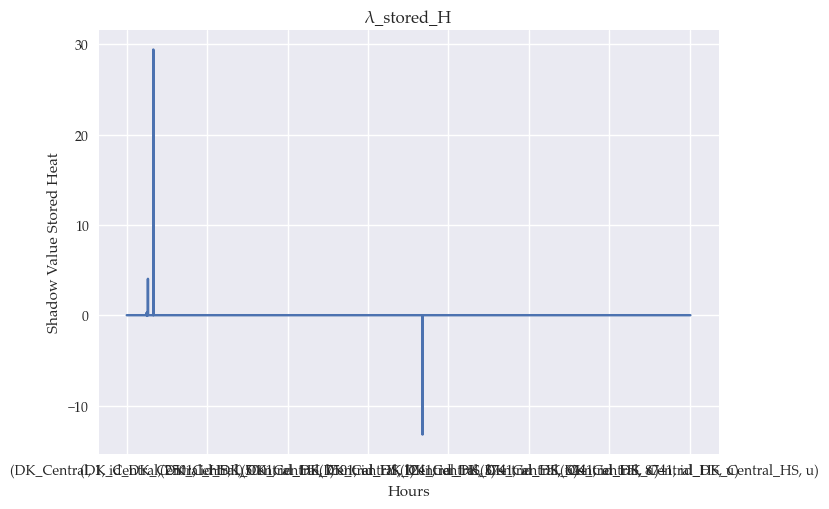

In [20]:
subset_stored_H = base_db['λ_stored_H'][base_db['λ_stored_H'].index.get_level_values('g_H') == 'DK_Central']

# For axis names
#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
subset_stored_H.plot()
plt.xlabel('Hours')
plt.ylabel('Shadow Value Stored Heat')
#plt.xticks(tick_positions, tick_positions)
plt.title('λ_stored_H')
plt.show()

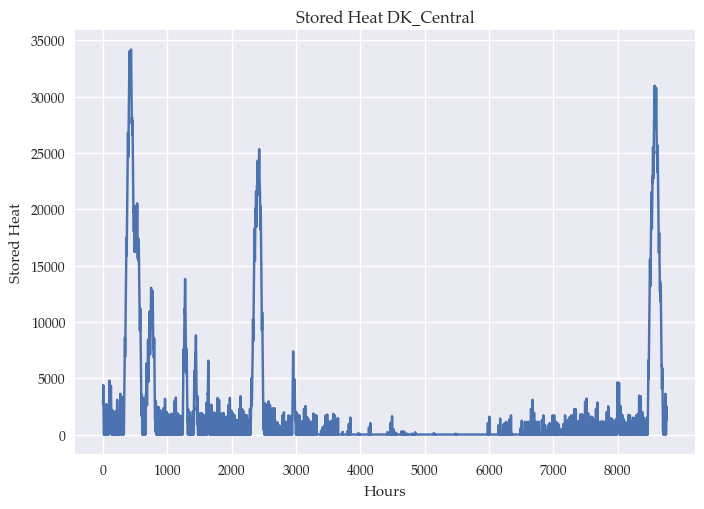

In [21]:
# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
base_db['stored_H'].plot()
plt.xlabel('Hours')
plt.ylabel('Stored Heat')
plt.xticks(tick_positions, tick_positions)
plt.title('Stored Heat DK_Central')
plt.show()

Plotting **marginalSystemCosts_H**:

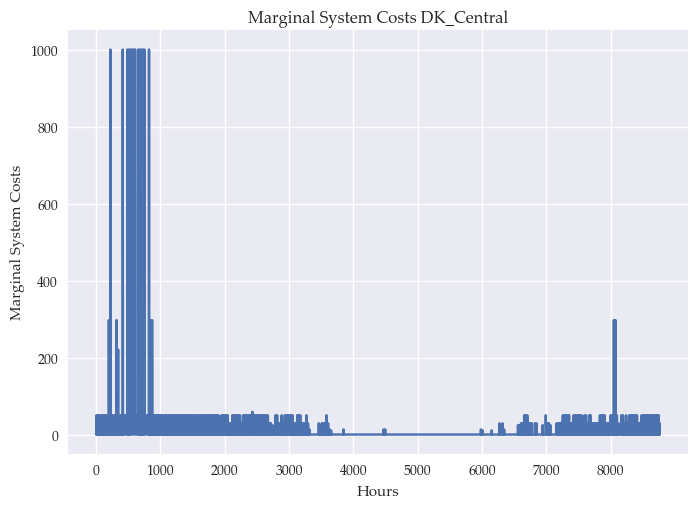

In [22]:
# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
base_db['marginalSystemCosts_H'].plot()
plt.xlabel('Hours')
plt.ylabel('Marginal System Costs')
plt.xticks(tick_positions, tick_positions)
plt.title('Marginal System Costs DK_Central')
plt.show()

## Increase Storage Capacity

These are the baseline storage capacities:

In [23]:
base_db['sCap']

id
id_DK_Central_HS    34181.241379
Name: sCap, dtype: float64

In the following, we will run an experiment where we are exogenously increase the capacity of the storage technology from the baseline levels. We will assume the same storage duration of **60.344828 hours** as in the baseline scenario.

We will also be extracting the following variables:

In [24]:
extract = ['marginalSystemCosts_E','marginalSystemCosts_H','stored_H','Welfare','Emissions', 'marginalEconomicValue', 'meanConsumerPrice_E', 'meanConsumerPrice_H']

In [40]:
# Setting
E2H = 60.344828 # The "energy storage to heat"-ratio/storage duration
maxcap = base_db['GeneratingCap_H']*2
loop = pd.Index(range(5), name = 'loop')
v0_GCap = pd.Series(base_db['GeneratingCap_H'], index = getTechs(['HS'],m.db))
vT_GCap = pd.Series(maxcap, index = v0_GCap.index)
v0_SCap = v0_GCap.mul(E2H)
vT_SCap = vT_GCap.mul(E2H)

grid_GCap = adjMultiIndex.addGrid(v0_GCap,vT_GCap,loop,'GeneratingCapacity').astype(int)
grid_SCap = adjMultiIndex.addGrid(v0_SCap,vT_SCap,loop,'sCap').astype(int)

In [41]:
grid_GCap

loop  id              
0     id_DK_Central_HS     566
1     id_DK_Central_HS     708
2     id_DK_Central_HS     849
3     id_DK_Central_HS     991
4     id_DK_Central_HS    1132
Name: GeneratingCapacity, dtype: int32

In [42]:
grid_SCap

loop  id              
0     id_DK_Central_HS    34181
1     id_DK_Central_HS    42726
2     id_DK_Central_HS    51271
3     id_DK_Central_HS    59817
4     id_DK_Central_HS    68362
Name: sCap, dtype: int32

We now run the counterfactual scenarios:

In [43]:
solution = m.loopSolveExtract(loop, [grid_GCap, grid_SCap], extract)

In [78]:
solution['stored_H']

g_H         h     id                loop
DK_Central  1     id_DK_Central_HS  0       2703.386032
                                    1       2703.386032
                                    2       2703.386032
                                    3       2703.386032
                                    4       2703.386032
                                               ...     
            8760  id_DK_Central_HS  0       2138.753633
                                    1       2138.753633
                                    2       2138.753633
                                    3       2138.753633
                                    4       2138.753633
Length: 43800, dtype: float64

In [82]:
%%capture
loop_id=loop[[0,1,2,3,4]]

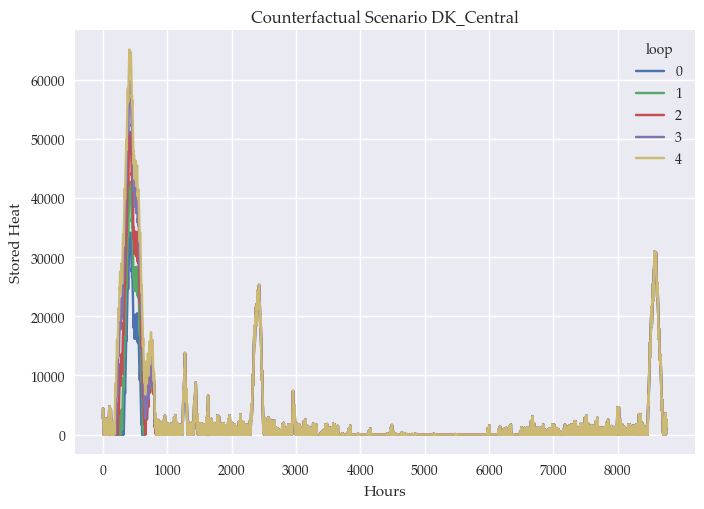

In [86]:
# Calculate tick positions for every 1000
tick_positions = range(0,  8761, 1000)

# Plot the subset Series
adj.rc_pd(solution['stored_H'],loop_id).unstack('loop').plot()
plt.xlabel('Hours')
plt.ylabel('Stored Heat')
plt.xticks(tick_positions,tick_positions)
plt.title('Counterfactual Scenario DK_Central')
plt.show()

In [89]:
start_hour = 1
end_hour = 1000

# Filter the Series for the specified range of hours
filtered_series = solution['stored_H'][(solution['stored_H'].index.get_level_values('h') >= start_hour) & (solution['stored_H'].index.get_level_values('h') <= end_hour)]

# Display the filtered Series
print(filtered_series)


g_H         h     id                loop
DK_Central  1     id_DK_Central_HS  0       2703.386032
                                    1       2703.386032
                                    2       2703.386032
                                    3       2703.386032
                                    4       2703.386032
                                               ...     
            1000  id_DK_Central_HS  0          0.000000
                                    1          0.000000
                                    2          0.000000
                                    3          0.000000
                                    4          0.000000
Length: 5000, dtype: float64


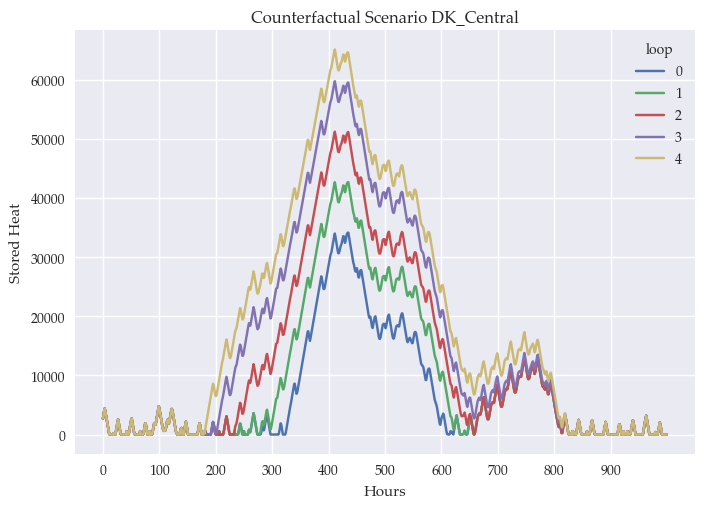

In [90]:
# Calculate tick positions for every 1000
tick_positions = range(0,  1000, 100)

# Plot the subset Series
adj.rc_pd(filtered_series,loop_id).unstack('loop').plot()
plt.xlabel('Hours')
plt.ylabel('Stored Heat')
plt.xticks(tick_positions,tick_positions)
plt.title('Counterfactual Scenario DK_Central')
plt.show()

In [70]:
tick_positions

range(0, 43800, 1000)

What to plot?

- CO2 Emissions
- Usage of Storage
- Marginal Economic value of storage
- seasonal storage?